# Malliavin Greeks under Black-Scholes Dynamics

This notebook is part of the materials that I used for my industry expert Lecture at KCL. Slides and further details will be available at a later date.

In this notebook, we are going to illustrate the estimation of Greek sensitivities using Malliavin Calculus.

In [122]:
import numpy as np

from aleatory.processes import GBM, BrownianMotion
import numpy as np
from scipy.stats import norm

%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
my_style = "https://raw.githubusercontent.com/quantgirluk/matplotlib-stylesheets/main/quant-pastel-light.mplstyle"
plt.style.use(my_style)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 100

## Process Dynamics
We are going to use a Geometric Brownian process, i.e. Black-Scholes world, to model the dynamics of the price of the underlying asset. This means that $X$ satisfies the following SDE

$$dX_t = r X_t dt + \sigma X_tdW_t,$$

with $X_0=x_0>0$, where $W_t$ denotes a standard Brownian Motion, and  both $r$ and  $\sigma$ are known parameters.

- r = 5%
- $\sigma$ = 10%
- $x_0=100$
- Maturity T=1

In [152]:
x0 = 100.0
r = 0.05
sigma = 0.1
T = 1.0

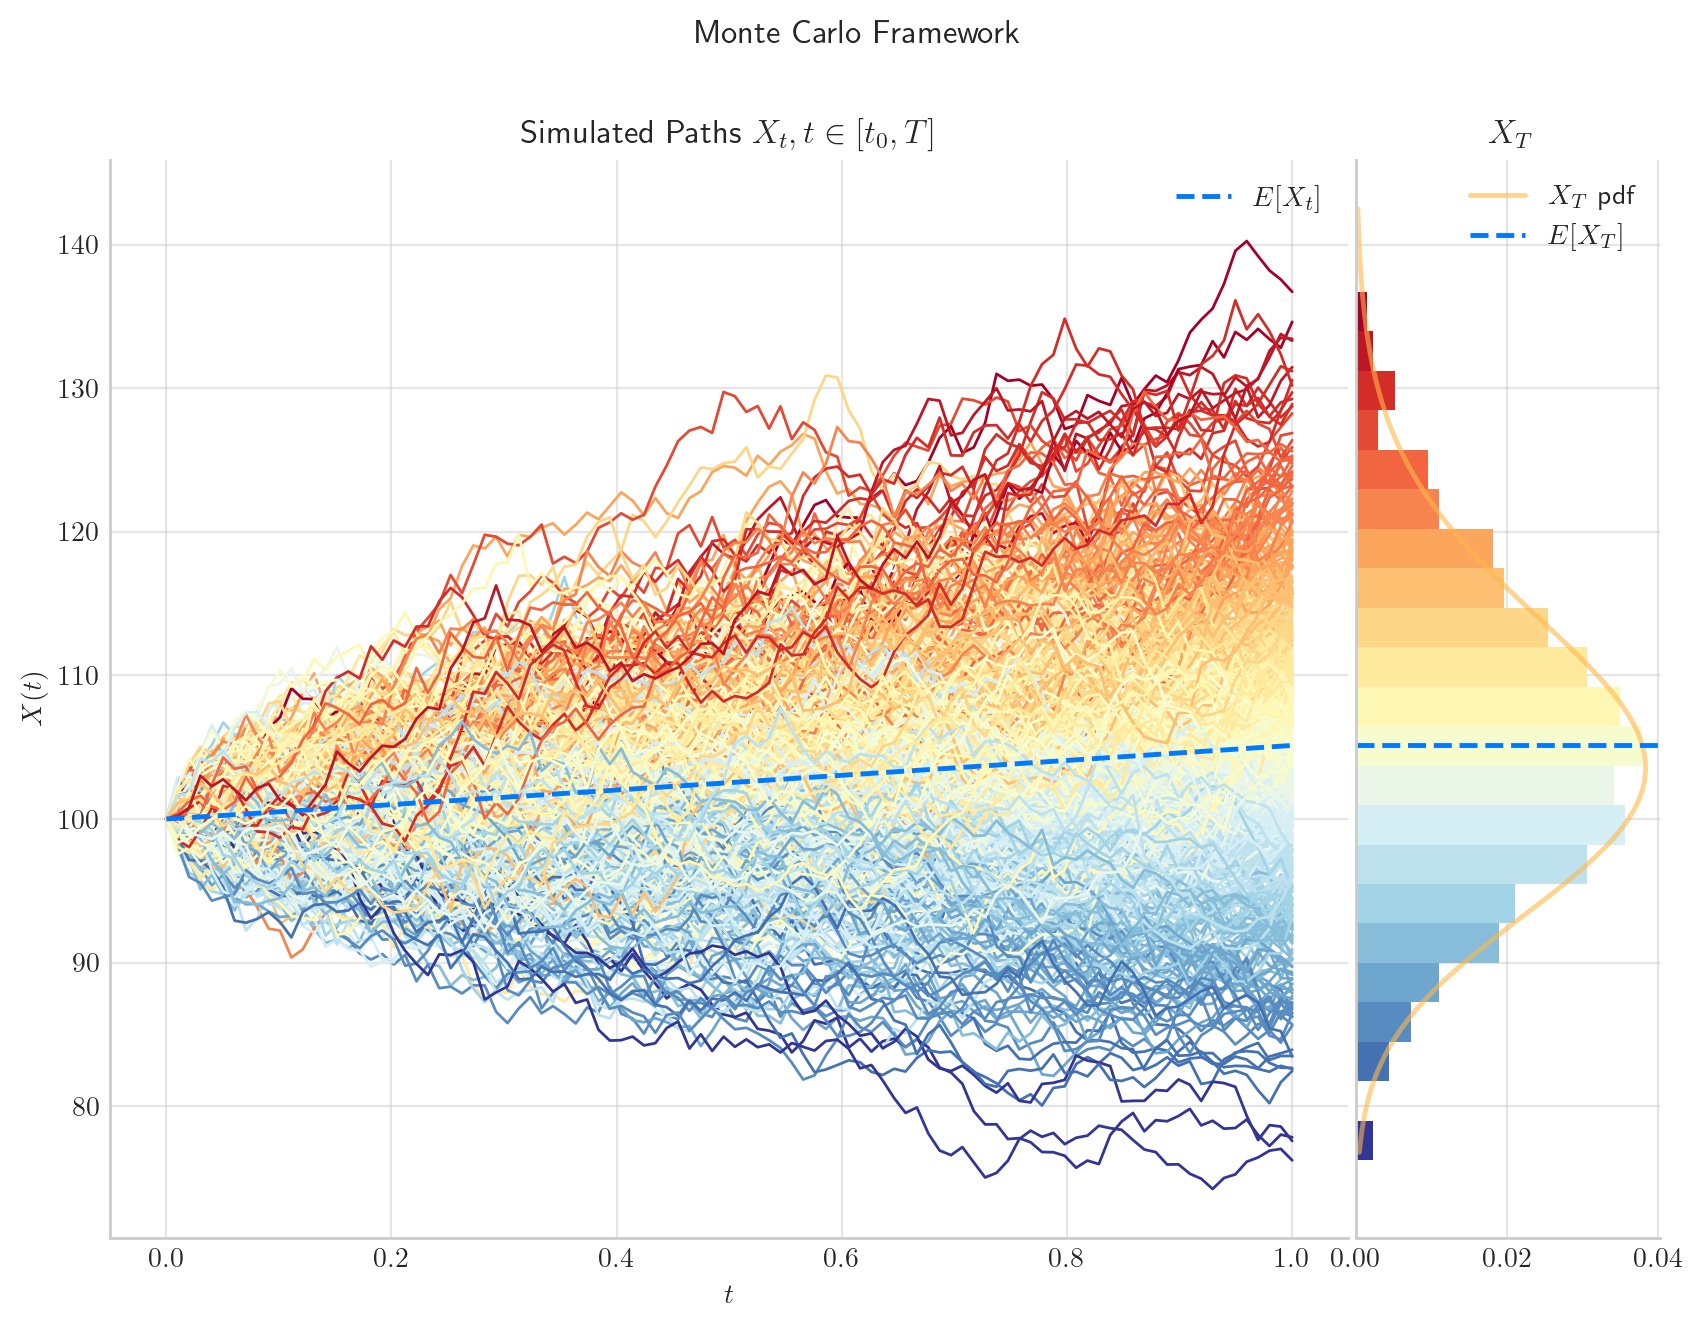

In [153]:
process = GBM(drift= r , volatility=sigma, initial=x0, T=T)  
process.draw(n=100, N=500, title='Monte Carlo Framework')
plt.show()

## Malliavin Weight

\begin{equation}
w = \dfrac{2 \int_0^T \dfrac{X_s}{\sigma} dW_s}{x \int_0^T X_t dt} + \dfrac{1}{x}
\end{equation}


```{note}
The weights only depend on the Dynamics and not on the payoff function!
```

## Payoff : European Option

In [ ]:
K=101 # Strike is going to be fixed in this notebook

def payoff(x, kind="call"):
    if kind == "call":
        return np.maximum(x-K, 0)
    elif kidn == "put":
        return np.maximum(K - x, 0)
    else:
        return 0

### Analytical Delta

In [150]:
d_plus = (np.log(x0/K)+(r + 0.5*sigma**2)*T)*(1.0/(sigma*np.sqrt(T)))
d_minus = d_plus - sigma*np.sqrt(T) 
std_normal = norm(loc=0, scale=np.sqrt(1))
delta = std_normal.cdf(d_plus)
delta

0.6738238303604167

### Numerical Estimates

In [ ]:
def estimate_delta_malliavin(payoff, r, sigma, x0, T, N):
    
    
    browniam_marginal = norm(loc=0, scale=np.sqrt(T))
    brownian_sample = browniam_marginal.rvs(N)
    gbm_sample = x0*np.exp((r - 0.5*sigma**2)*T + sigma*brownian_sample)
    
    constant = np.exp(-1.0*r*T)/(sigma*x0*T)

    deltas = []
    sizes = range(100, N+1, 100)
    for k in sizes:
        
        mc_estimator = np.mean(payoff(gbm_sample[:k])*brownian_sample[:k])
        delta = constant*mc_estimator
        deltas.append(delta)
        
    
    return sizes, deltas

In [129]:
N = 100000
sizes, malliavin_deltas = estimate_delta_malliavin(payoff=payoff,  r=r, sigma=sigma, x0=x0, T=T, N=N)

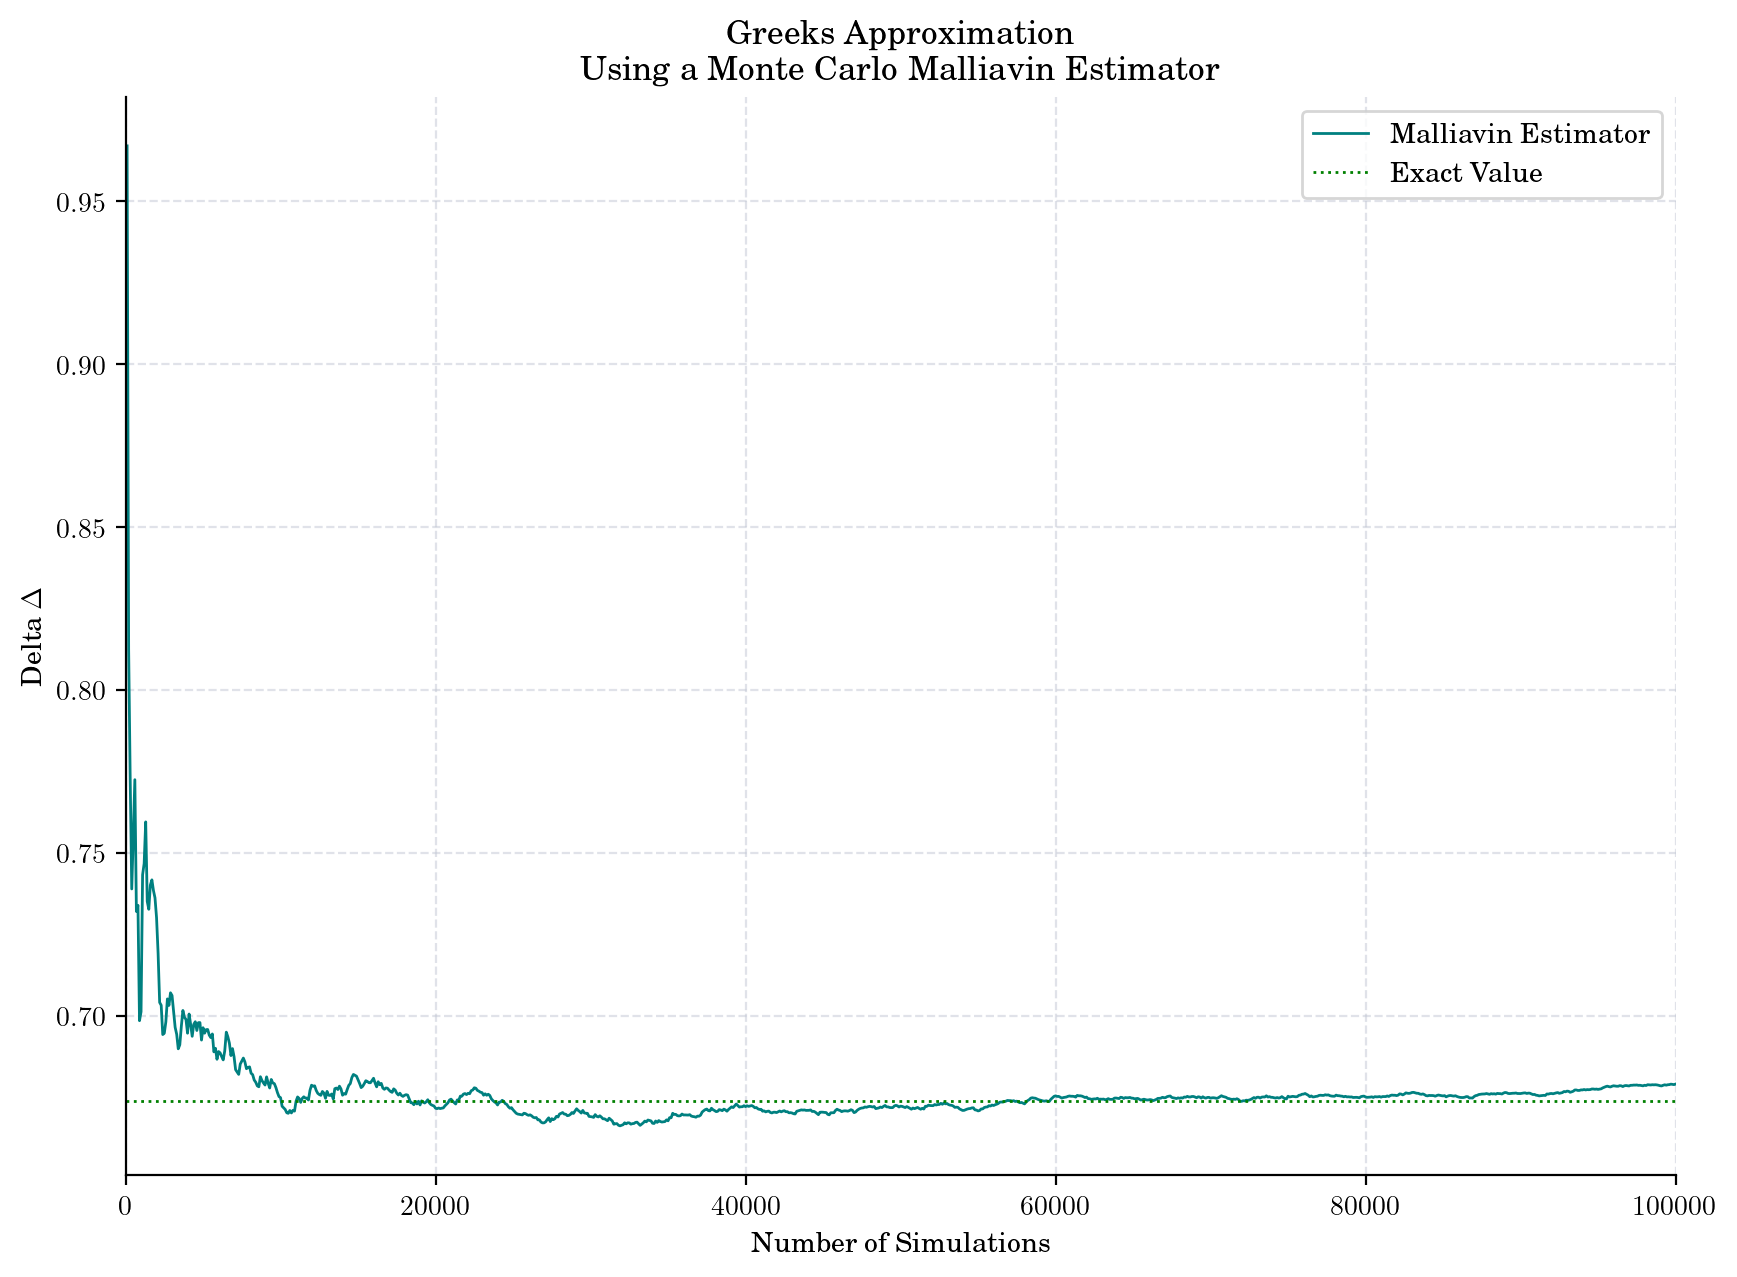

In [130]:
plt.plot(sizes, malliavin_deltas, color="teal", label="Malliavin Estimator")
plt.hlines(delta, 0, sizes[-1], color="green", linestyle=":", label="Exact Value")
plt.xlim([0.0, sizes[-1]])
plt.ylabel("Delta $\Delta$")
plt.xlabel("Number of Simulations")
plt.title("Greeks Approximation\n Using a Monte Carlo Malliavin Estimator")
plt.legend()
plt.show()

In [131]:
def estimate_delta_fd(payoff, r, sigma, x0, T, N, epsilon=0.001):

    browniam_marginal = norm(loc=0, scale=np.sqrt(T))
    
    brownian_sample = browniam_marginal.rvs(N)
    gbm_sample_up= (x0 + epsilon)*np.exp((r - 0.5*sigma**2)*T + sigma*brownian_sample)
    gbm_sample_down = (x0 - epsilon)*np.exp((r - 0.5*sigma**2)*T + sigma*brownian_sample)
    constant = np.exp(-1.0*r*T)
    
    pv_plus = payoff(gbm_sample_up)
    pv_minus = payoff(gbm_sample_down)
    
    deltas = []
    sizes = range(100, N+1, 100)
    for k in sizes:
        
        fd = np.mean((pv_plus[:k] - pv_minus[:k])/(2.0*epsilon))
        delta = constant*fd
        deltas.append(delta)
        
    return sizes, deltas

In [132]:
sizes, fd_deltas = estimate_delta_fd(payoff=payoff, r=r, sigma=sigma, x0=x0, T=T, N=N)

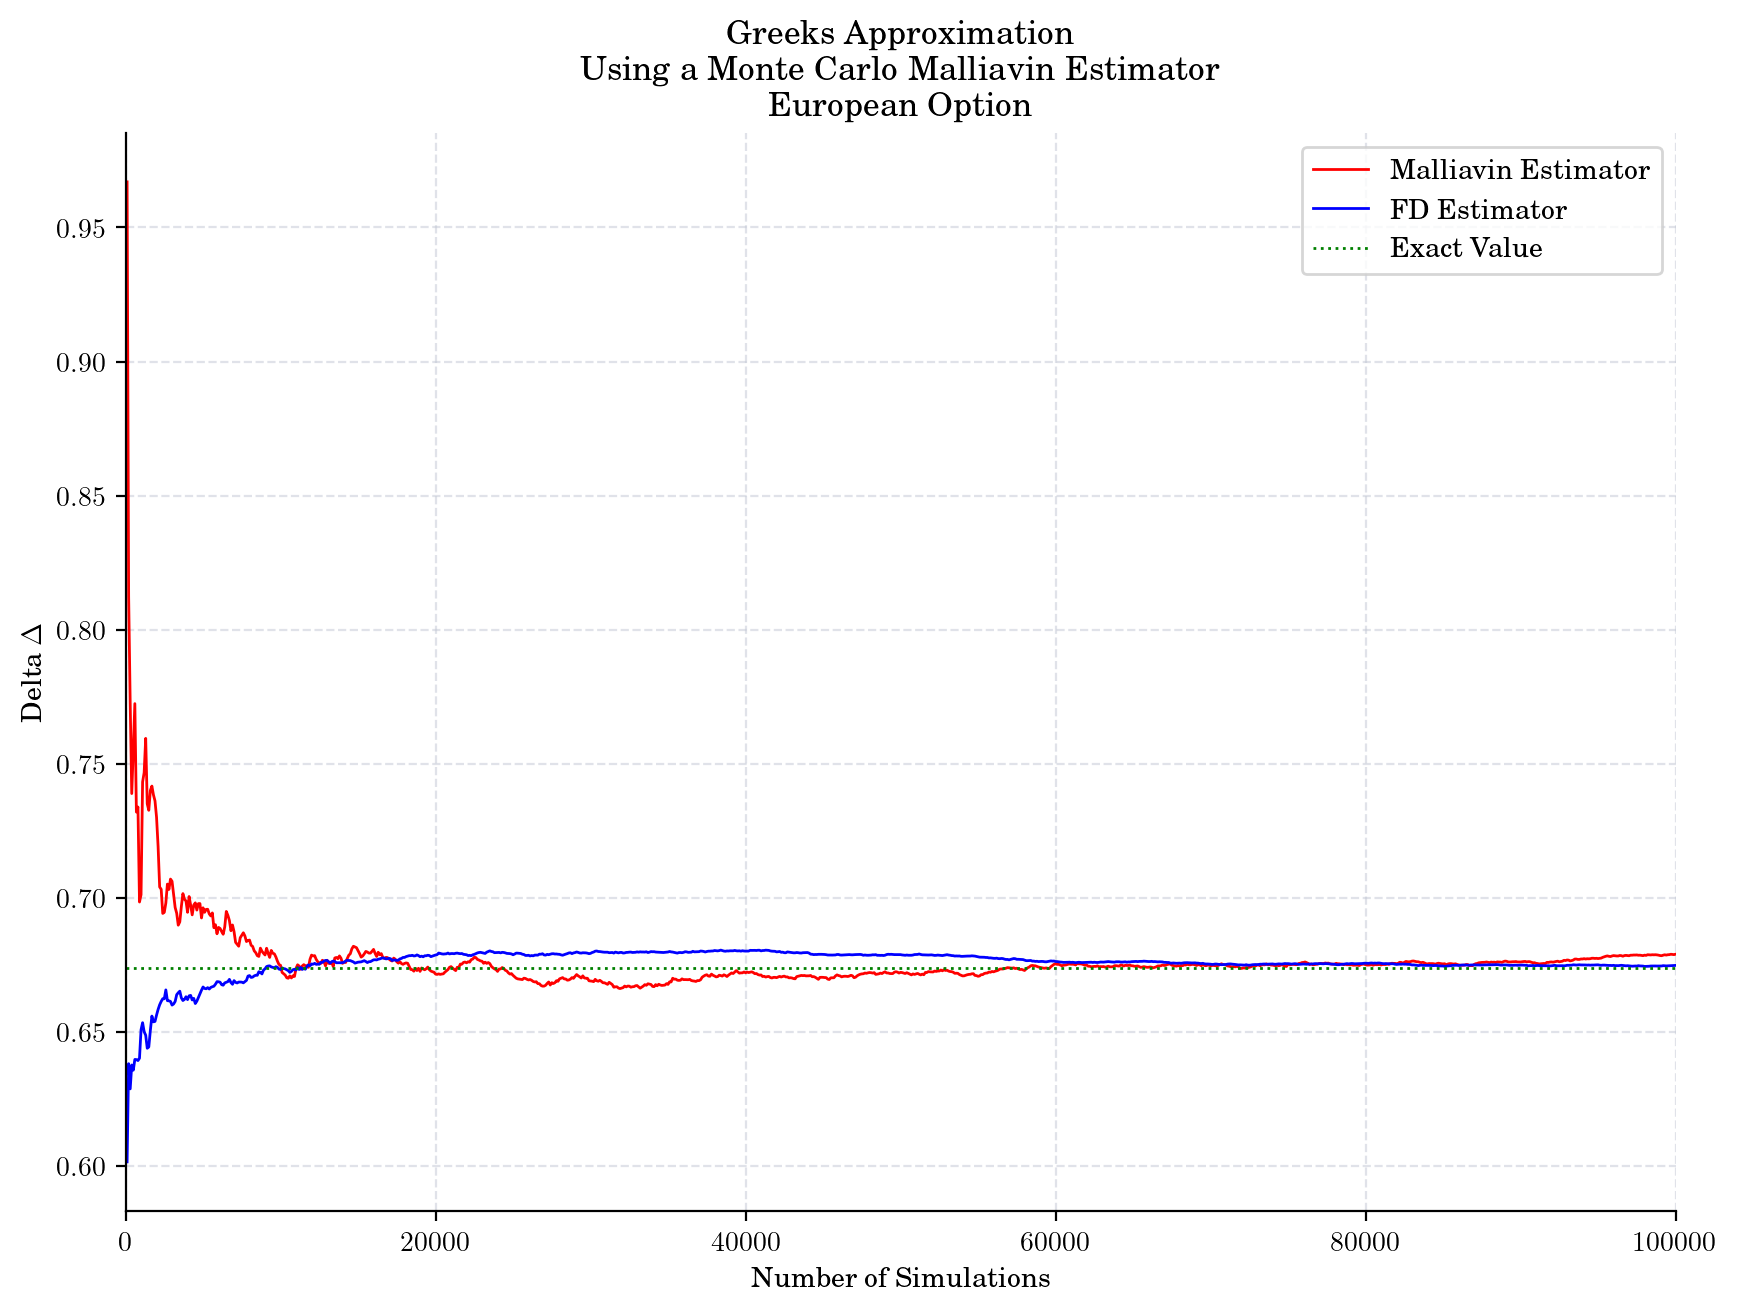

In [133]:
plt.plot(sizes, malliavin_deltas, color="red", label="Malliavin Estimator")
plt.plot(sizes, fd_deltas, color="blue", label="FD Estimator")
plt.hlines(delta, 0, sizes[-1], color="green", linestyle=":", label="Exact Value")
plt.xlim([0.0, sizes[-1]])
plt.ylabel("Delta $\Delta$")
plt.xlabel("Number of Simulations")
plt.title("Greeks Approximation\n Using a Monte Carlo Malliavin Estimator\n European Option")
plt.legend()
plt.show()

## Payoff : Digital Option

In [134]:
def payoff_binary(x, kind="call"):
    if kind == "call":
        pay = np.maximum(x-K, 0)
        return np.array( pay !=0 , dtype=int)
    elif kidn == "put":
        pay = np.maximum(K - x, 0)
        return np.array( pay !=0 , dtype=int)
    else:
        return 0

In [135]:
sizes, fd_deltas_binary = estimate_delta_fd(payoff_binary, r, sigma, x0, T, N=N)

In [136]:
sizes, malliavin_deltas_binary = estimate_delta_malliavin(payoff_binary, r, sigma, x0, T, N=N)

In [137]:
delta_binary =  (np.exp(-r*T)*std_normal.pdf(d_minus))/(sigma*x0*np.sqrt(T) )
delta_binary

0.03568775695099892

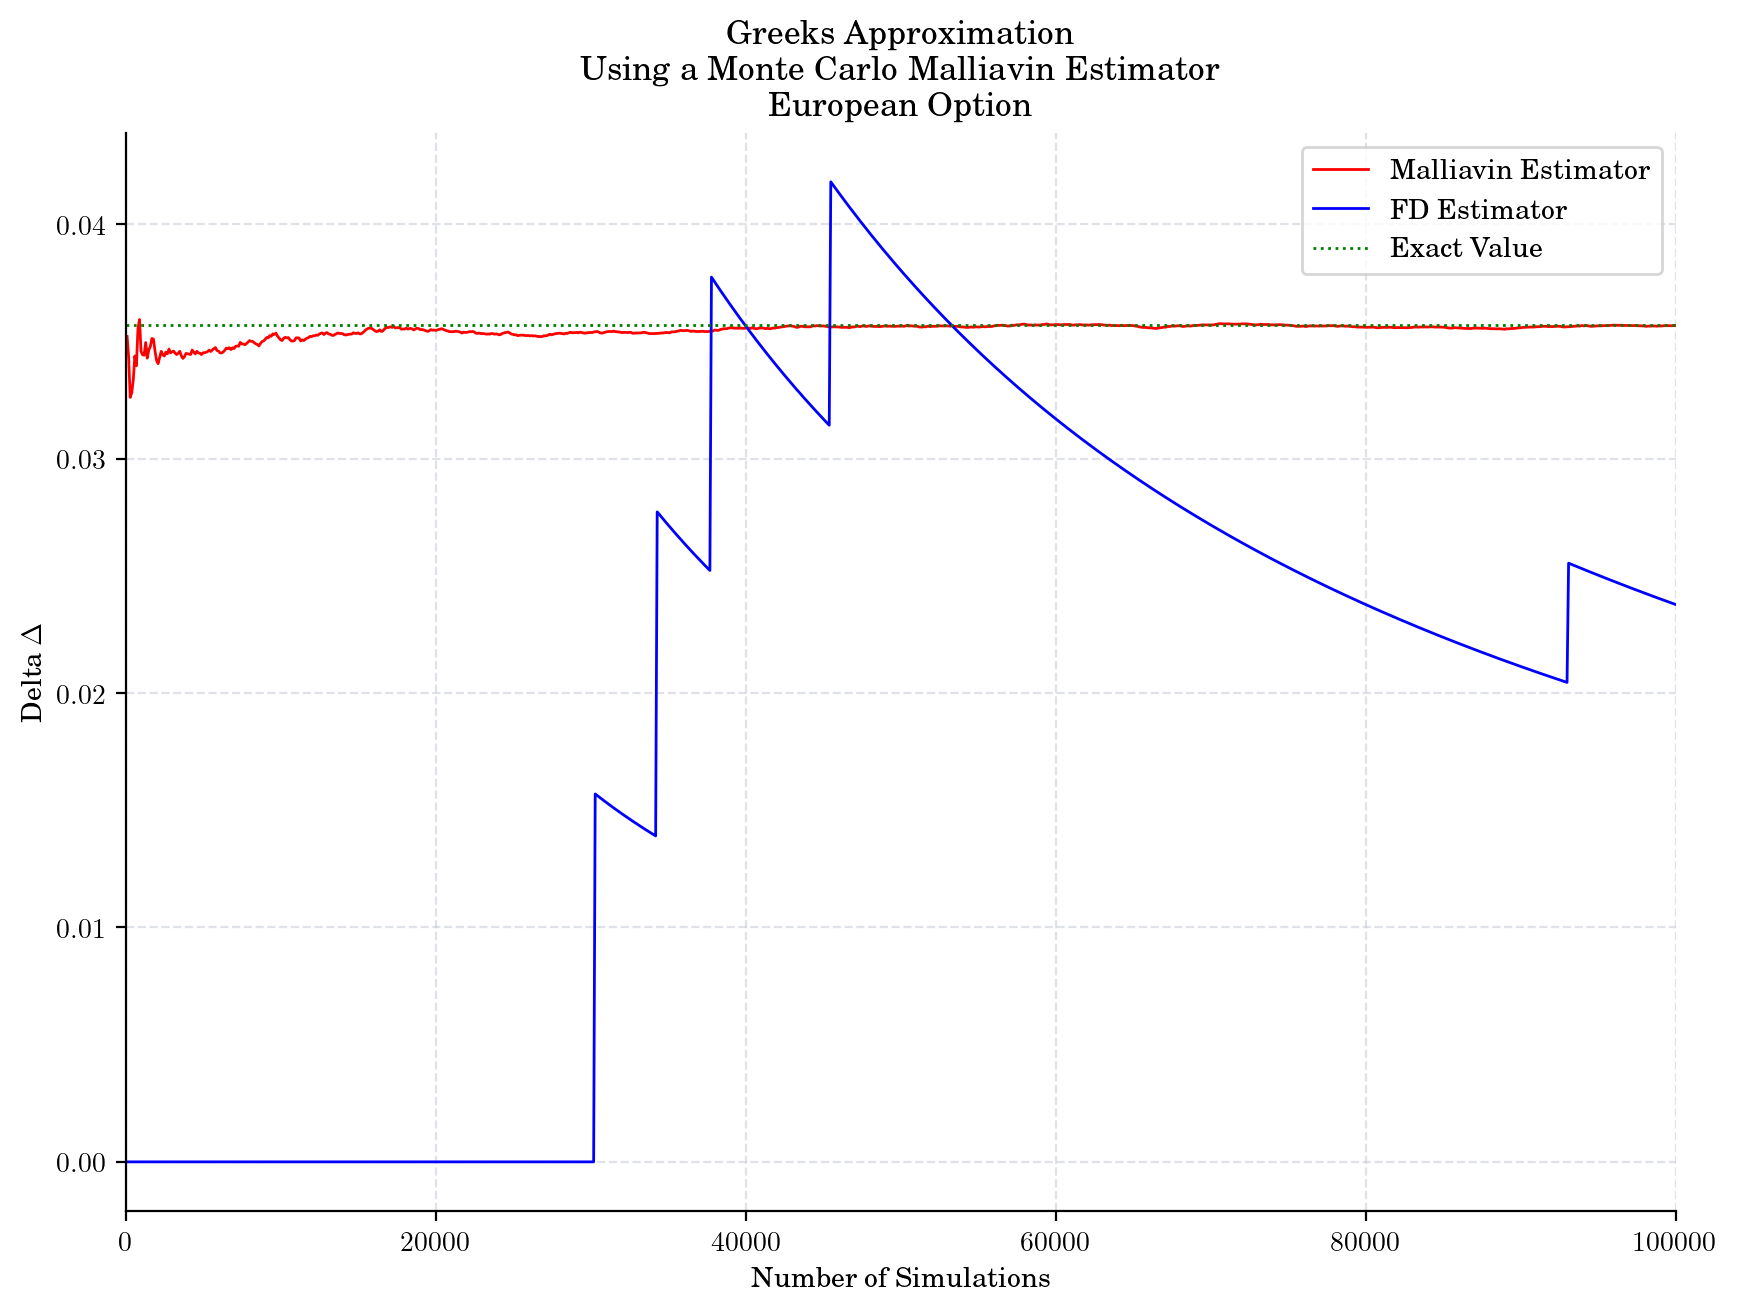

In [138]:
plt.plot(sizes, malliavin_deltas_binary, color="red", label="Malliavin Estimator")
plt.plot(sizes, fd_deltas_binary, color="blue", label="FD Estimator")
plt.hlines(delta_binary, 0, sizes[-1], color="green", linestyle=":", label="Exact Value")
plt.xlim([0.0, sizes[-1]])
# plt.ylim([0.2, 0.7])
plt.ylabel("Delta $\Delta$")
plt.xlabel("Number of Simulations")
plt.title("Greeks Approximation\n Using a Monte Carlo Malliavin Estimator\n European Option")
plt.legend()
plt.show()

In [139]:
sizes, malliavin_deltas_binary = estimate_delta_malliavin(payoff_binary, r, sigma, x0, T, N=2*N)
sizes, fd_deltas_binary = estimate_delta_fd(payoff_binary, r, sigma, x0, T, N=2*N)

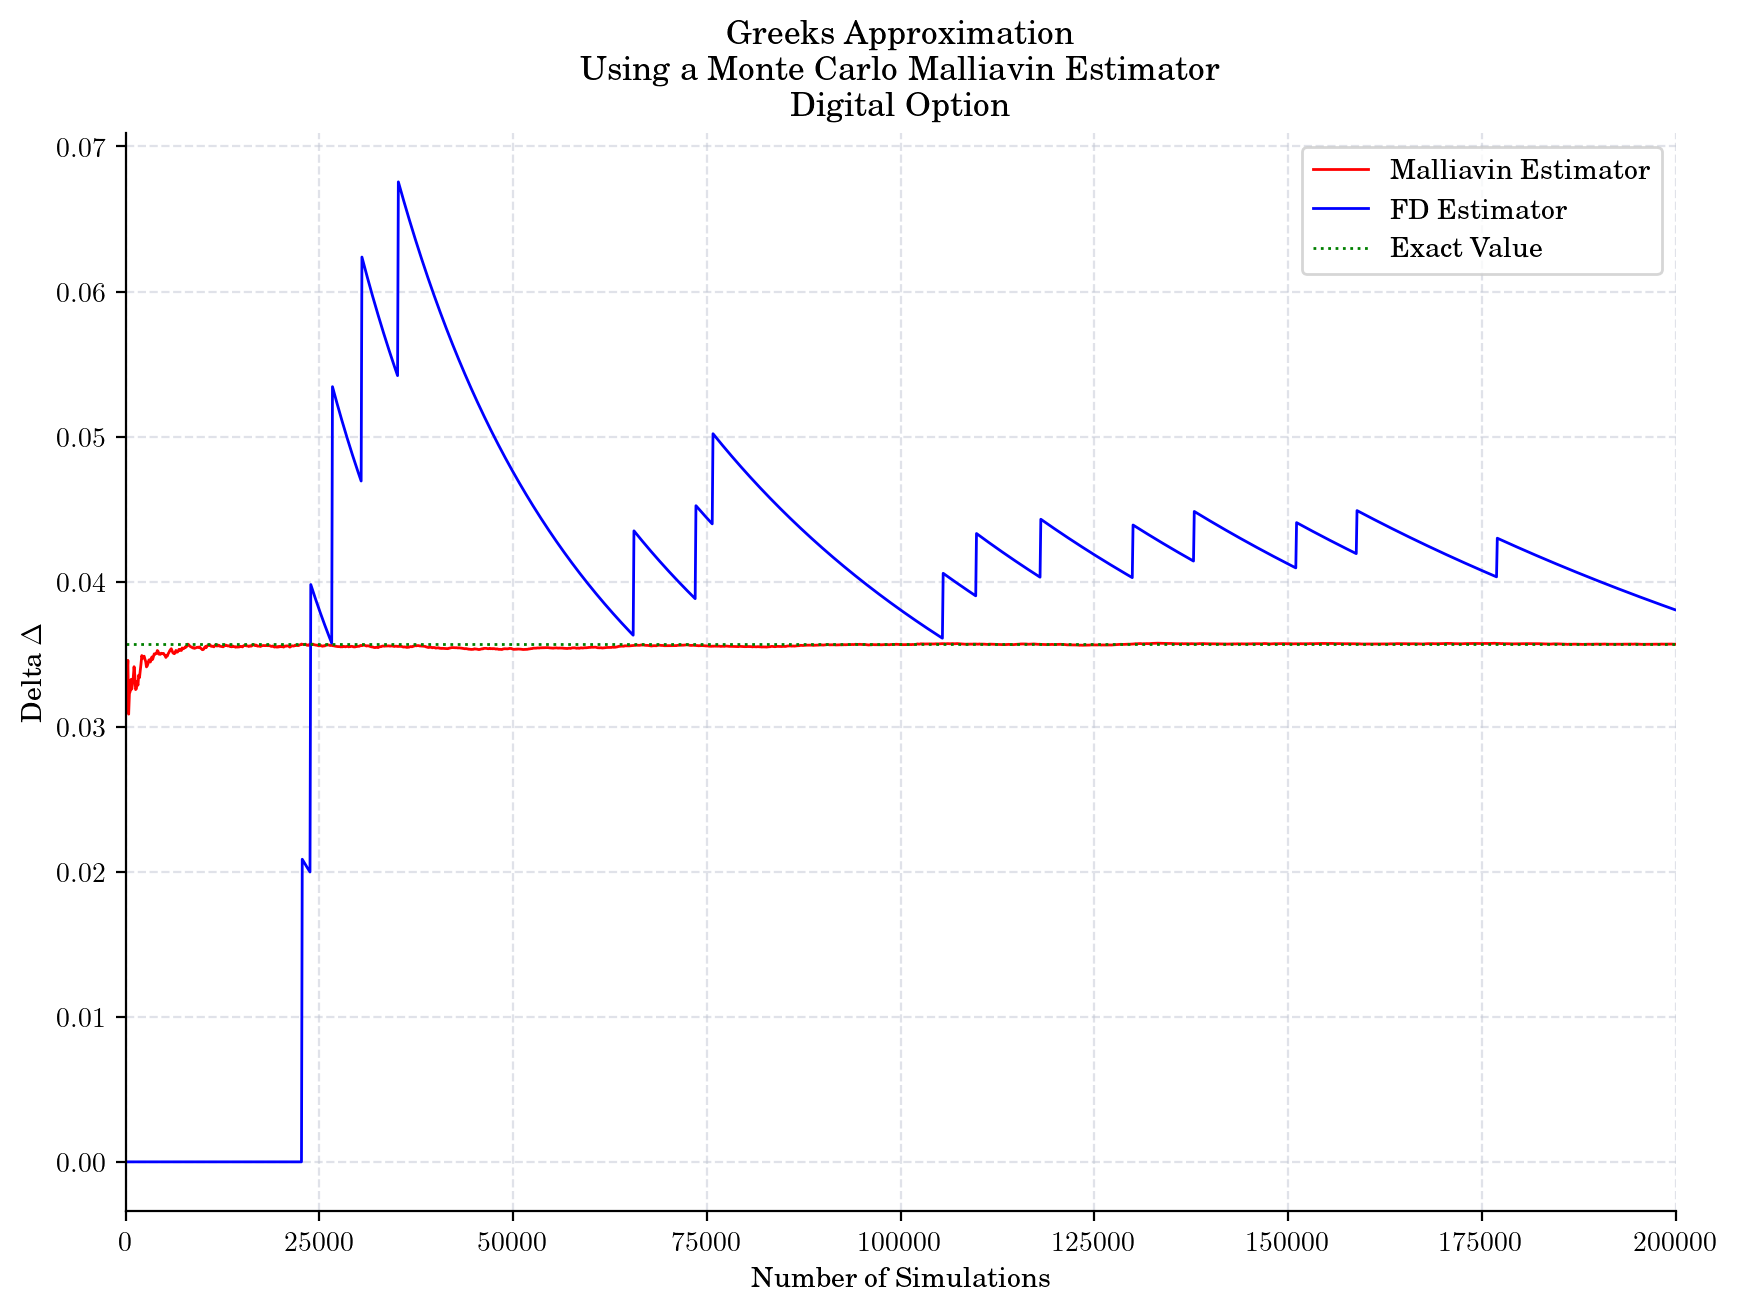

In [140]:
plt.plot(sizes, malliavin_deltas_binary, color="red", label="Malliavin Estimator")
plt.plot(sizes, fd_deltas_binary, color="blue", label="FD Estimator")
plt.hlines(delta_binary, 0, sizes[-1], color="green", linestyle=":", label="Exact Value")
plt.xlim([0.0, sizes[-1]])
plt.ylabel("Delta $\Delta$")
plt.xlabel("Number of Simulations")
plt.title("Greeks Approximation\n Using a Monte Carlo Malliavin Estimator\n Digital Option")
plt.legend()
plt.show()

## Payoff Asian Option

In [141]:
def payoff_asian(x, kind="call"):
    if kind == "call":
        pay = np.mean(x)-K
        return np.maximum(pay, 0)
    elif kidn == "put":
        pay = K - np.mean(x)
        return np.maximum(pay, 0)
    else:
        return 0

In [142]:
def estimate_delta_fd_asian(payoff, r, sigma, x0, T, N, epsilon=0.001):
    
    BM = BrownianMotion(T=T) # Brownian Motion
    brownian_sim = np.asarray(BM.simulate(n=100, N=N))
    times= BM.times

    gbm_sample_up = (x0+epsilon)*np.exp((r - 0.5*sigma**2)*times + sigma*brownian_sim)
    gbm_sample_down = (x0-epsilon)*np.exp((r - 0.5*sigma**2)*times + sigma*brownian_sim)
    
    constant = np.exp(-1.0*r*T)
    
    pvps = []
    pvms = []
    sizes = range(100, N+1, 100)
    for i in range(len(gbm_sample_up)):
        pv_plus = payoff(x = gbm_sample_up[i])
        pvps.append(pv_plus)
        pv_minus = payoff(x = gbm_sample_down[i])
        pvms.append(pv_minus)
        
    
    deltas = []
    sizes = range(100, N+1, 100)
    for k in sizes:
        estimator = constant*(np.mean(pvps[:k-1])- np.mean(pvms[:k-1]))/(2.0*epsilon)
        deltas.append(estimator)

            
    return sizes, deltas

In [143]:
def estimate_delta_malliavin_asian(payoff, r, sigma, x0, T, N):
    BM = BrownianMotion(T=T) # Brownian Motion
    brownian_sim = np.asarray(BM.simulate(n=100, N=N))
    times= BM.times
    mu = r - 0.5*sigma**2
    gbm_sim = x0*np.exp(mu*times + sigma*brownian_sim) # N paths
    constant = (2.0*np.exp(-1.0*r*T))/(x0*sigma**2)    
    
    deltas = []
    n = len(gbm_sim[0])
    for i in range(len(gbm_sim)):
        weight =((gbm_sim[i,n-1] - x0)/np.mean(gbm_sim[i]) ) - mu
        delta =  constant*payoff(gbm_sim[i])*weight
        deltas.append(delta)    
    estimators =[]
    sizes = range(100, N+1, 100)
    for k in sizes:
        estimators.append(np.mean(deltas[:k-1]))
            
    return sizes, estimators
    

In [ ]:
sizes, deltas_fd_asian = estimate_delta_fd_asian(payoff_asian, r=r, sigma=sigma, x0=x0, T=T, N=N)

In [145]:
deltas_fd_asian[-1]

0.5984101841216706

In [ ]:
sizes, deltas_asian_malliavin = estimate_delta_malliavin_asian(payoff_asian,r, sigma, x0, T, N=N)

In [147]:
deltas_asian_malliavin[-1]

0.5954473043669034

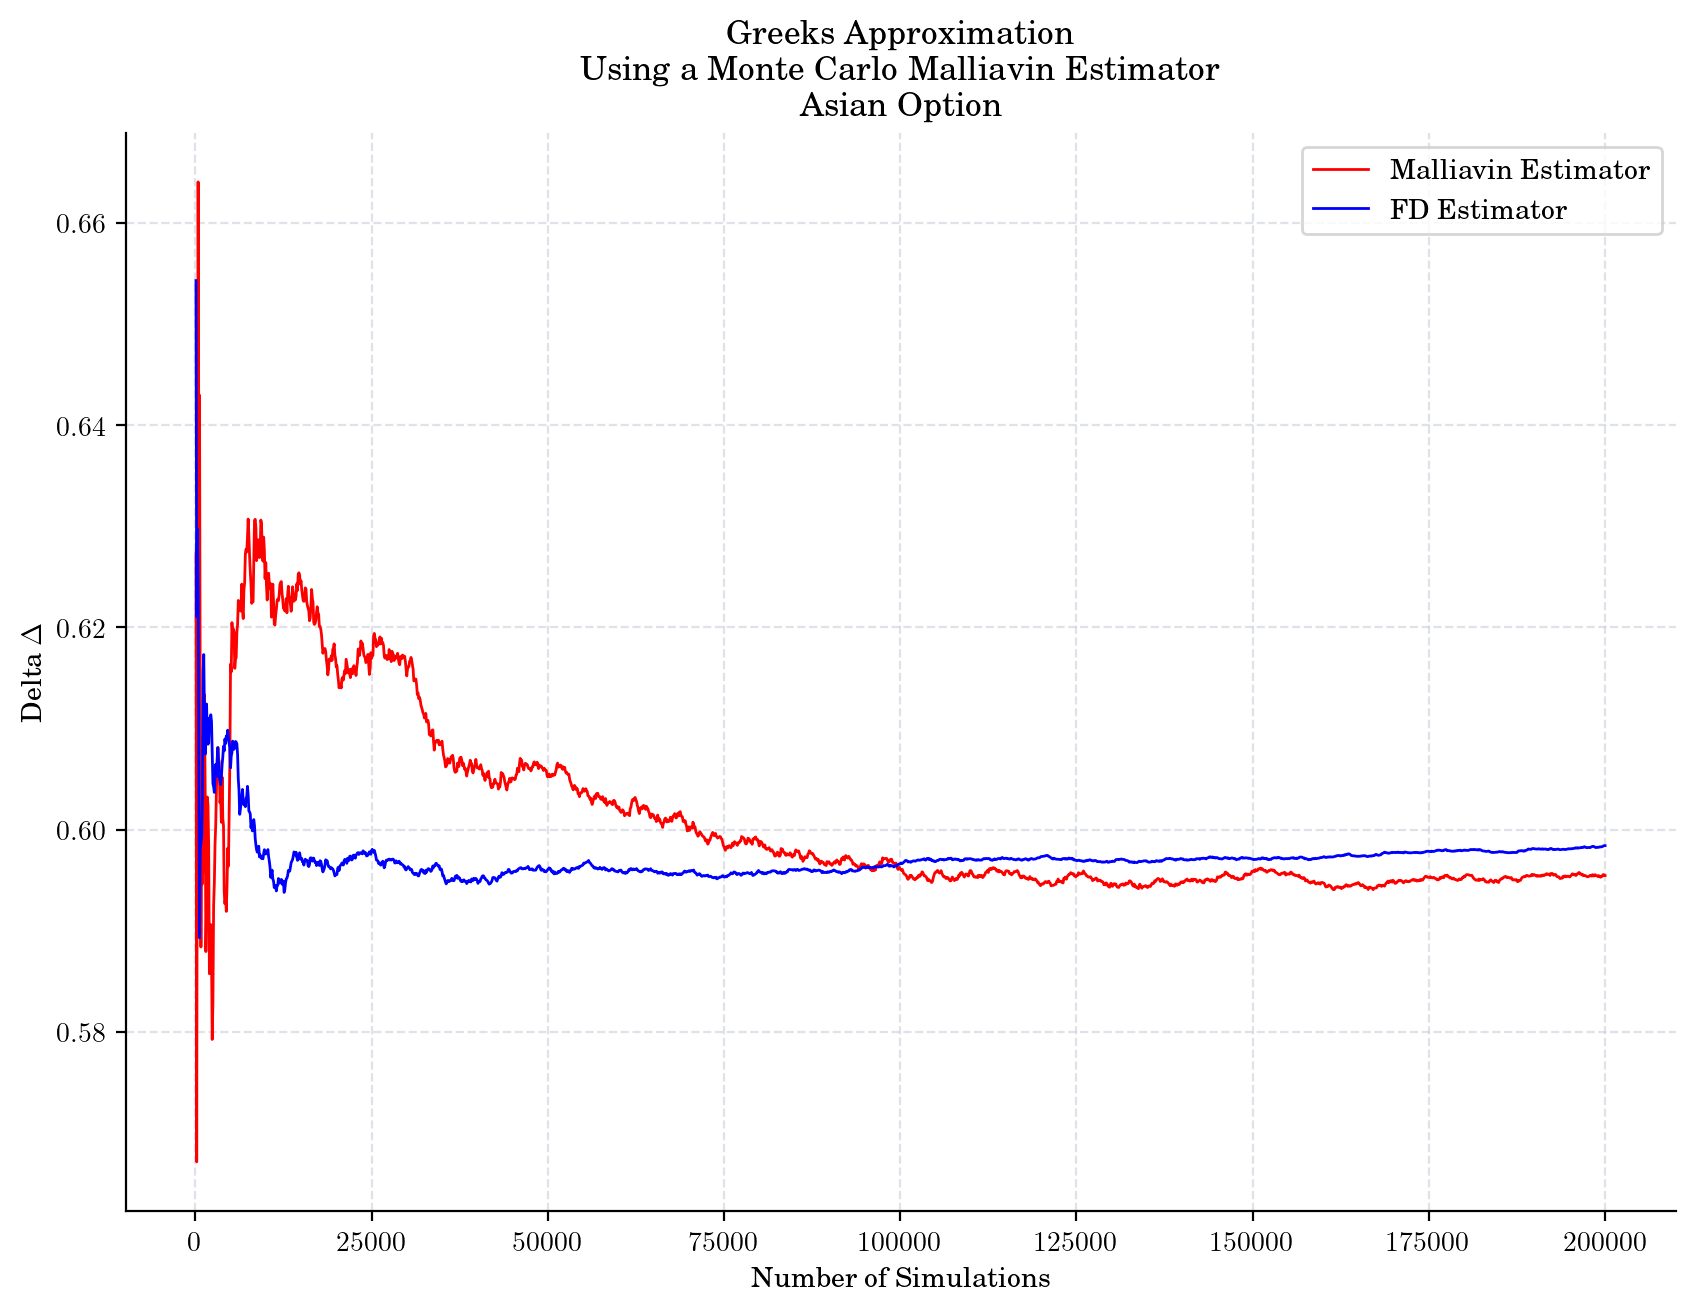

In [148]:
plt.plot(sizes, deltas_asian_malliavin, color="red", label="Malliavin Estimator")
plt.plot(sizes, deltas_fd_asian, color="blue", label="FD Estimator")
plt.ylabel("Delta $\Delta$")
plt.xlabel("Number of Simulations")
plt.title("Greeks Approximation\n Using a Monte Carlo Malliavin Estimator\n Asian Option")
plt.legend()
plt.show()